# This code analyze the dynamic response of the pressure measurement system
## We only use the sensor in front of the wing nose, ${C_p}_0$, as this snesor does not influenced by the separation flow.
## Also only use the case in which the angle of attach does not change, to make sure no movement in horizontal.
## Therefore, only case 10, case 14, case18, case 21, case26, case 30 can be used here
- $C_p = \frac{p_{\infty} + \frac{1}{2}*\rho*u^2 - p_{\infty}}{\frac{1}{2}*\rho*(U_{\infty})^2}$

- $C_p = (\frac{u}{u_{\infty}})^2$

- $U_{\infty} = 1.0$ m/s

# load package and prepare data

In [1]:
task = 'predict' 
force = 'CL'     
filt = 'no filter' 
ensemble_num = 30

if task == 'cross_validation':
    folds = 7
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

# Set the font family to Times New Roman
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'

from keras import backend as K
import numpy as np  #Mathmatical library
import pandas as pd #for data load

import matplotlib.pyplot as plt #Plot
from tqdm import tqdm as tqdm
from scipy.signal import bessel
from scipy.signal import filtfilt

# initialize the data
history_all = {}
predictions_A = {}
predictions_B = {}

# folder path

data_path = './train_dataframe/gust_dataframe.csv'

# read the excel data
gust_origin = pd.read_csv(data_path)

# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j])  # bessel for CP
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

# check filter result

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000) - 500) / f / T

if filt == 'bessel':
    ii = 13 # case to show
    case_to_show = 'case_' + str(ii).zfill(2)
    cp_to_show   = [-3,-4] # -3 is p0 (stagnation point), -4 is p16(training edge point)
    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, no filtered', color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, bessel filtered', color='b', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='b', linewidth=2)
    ax.legend()
    ax.margins(x=0)
    ax.set_xlabel('$t*$')
    ax.set_xticks(np.arange(-1,8))
    ax.set_xlim(-1,6.5)
    ax.set_ylabel('$C_{P}$')
    ax.set_ylim(-4.5,6)
    ax.grid(color='k', linestyle='-', linewidth=0.1)
    
elif filt == 'no filter':
    print('No filter. No compare.')
else:
    print('Error. Please define your filter.')

# fig.savefig('CP_Filter_case_%d_port%d.png' % (ii,0), bbox_inches='tight', dpi=300)
# fig.savefig('CP_Filter_case_%d_port%d.svg' % (ii,0), bbox_inches='tight')

# retrieve CP, 16(CP) + 16(CP_1st_order) + 16(CP_2nd_order) = 48 columns in total
# simply drop CL and CD, then the rest is CP
CP = gust.drop(['CL','CD'],axis=1, inplace=False)
CP.head()

# retrieve CL and CD
CL = gust[['CL']]
CD = gust[['CD']]
gust[[force]].head()

# retrieve for 8 different folds
# read the split .txt file; the number means the cases for test
split_path = './train_dataframe/delta_wing_32cases_split_random.txt'
with open(split_path, 'r') as file1:    
    fold_split = file1.read().splitlines()       # split by \n
fold_split = fold_split[1:] # drop the head line
for i in range(8):
    fold_split[i] = fold_split[i][9:].split()    # split by space; the number starts from 10th character.
    for j in range(4):
        fold_split[i][j] = int(fold_split[i][j]) # convert string to int
fold_split

# define the 32 case number
case_all_num = np.arange(gust.index.nunique()) + 1
print(case_all_num)
print(case_all_num.shape)

# find the case number for train and test cases;
if task == 'cross_validation':
    train_case = [ [0]*24 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for cross validation folds: fold1~fold7
    for i in range(folds): 
        train_case_temp = np.setdiff1d( case_all_num, np.concatenate((fold_split[i], fold_split[-1]))) 
        # drop test case and the last one (which is for fold 8 , final test)
        test_case_temp  = fold_split[i]

        # conbine to 'case_nn' sample for train and test case; prepare for next step
        for j in range(len(train_case_temp)):
            train_case[i][j] = 'case_' + str(train_case_temp[j]).zfill(2)
        for k in range(len(test_case_temp)):
            test_case[i][k]  = 'case_' + str(test_case_temp[k]).zfill(2)
            
elif task == 'predict': 
    train_case = [ [0]*28 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for test fold: fold8  
    train_case_temp = np.setdiff1d(case_all_num, fold_split[-1])
    test_case_temp  = fold_split[-1]
    for jj in range(len(train_case_temp)):
        train_case[-1][jj] = 'case_' + str(train_case_temp[jj]).zfill(2)
    for kk in range(len(test_case_temp)):
        test_case[-1][kk]  = 'case_' + str(test_case_temp[kk]).zfill(2)

else:
    print('Error. Please define your task.')

print(test_case[0])
print('Done!')

#  prepare for train and test data sets
if task == 'cross_validation':
    F_train_rec = np.zeros([folds,60000,1]) # 24*2500 = 60000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,60000,48])
    P_test_rec  = np.zeros([folds,10000,48])

    for i in range(folds): # 7 folds for training, the last one is for test, not retrieve here, since this is for training
        if force == 'CL':
            F_train_rec[i] = CL.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CL.loc[test_case[i]].to_numpy()
        elif force == 'CD':
            F_train_rec[i] = CD.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CD.loc[test_case[i]].to_numpy()
        else:
            print('Error. Please define force.')

        P_train_rec[i] = CP.loc[train_case[i]].to_numpy()
        P_test_rec[i]  = CP.loc[test_case[i]].to_numpy()

elif task == 'predict':
    F_train_rec = np.zeros([folds,70000,1]) # 28*2500 = 70000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,70000,16])
    P_test_rec  = np.zeros([folds,10000,16])
    
    if force == 'CL':
        F_train_rec[0] = CL.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CL.loc[test_case[0]].to_numpy()
    elif force == 'CD':
        F_train_rec[0] = CD.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CD.loc[test_case[0]].to_numpy()
    else:
        print('Error. Please define force.')

    P_train_rec[0] = CP.loc[train_case[0]].to_numpy()
    P_test_rec[0]  = CP.loc[test_case[0]].to_numpy()
    
else:
    print('Error. Please define your task.')
    
print('Done')

F_train = F_train_rec[0][:,:]   # change to 2d for training
F_test  = F_test_rec[0][:,:]
P_train = P_train_rec[0][:,:]
P_test  = P_test_rec[0][:,:]

print('Done!')

Define the task complete.
(80000, 18)
No filter. No compare.
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
(32,)
['case_13', 'case_20', 'case_25', 'case_28']
Done!
Done
Done!


In [2]:
CP.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t
case_number,,,,,,,,,,,,,,,,
case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897
case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896
case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073
case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709
case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797


# Calculate the velocity

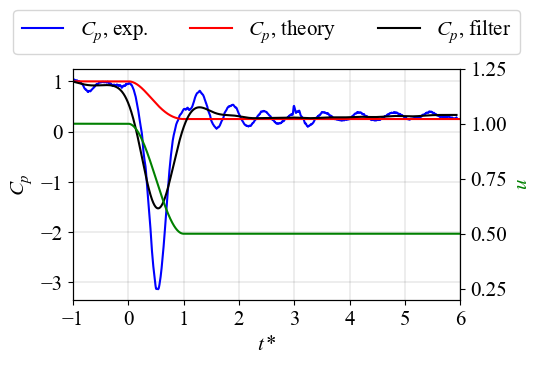

In [129]:
cp_case = CP.loc['case_30'].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

t_star = np.linspace(-1,6.5,2500) 
# plot cp, and align the cp so that gust starts from t*=0
ax.plot(t_star[:(2500-190)], cp_case[190:2500,-1], 'blue', label='$C_p$, exp.')
ax.set_xticks(np.arange(-1,8))
ax.set_xlim(-1,6)
ax.grid(color='k', linestyle='-', linewidth=0.1)

def set_velocity(time):
    if -1 <= time < 0:
        velocity = 1
    elif 0 <= time < 1:
        velocity = 0.25*np.cos(2 * np.pi / 2 * time) + 0.75
    else:
        velocity = 0.5
    return velocity

velocities = np.array([set_velocity(t) for t in t_star])
ax2 = ax.twinx()
ax2.plot(t_star, velocities, 'green')
ax2.set_ylim([0.2,1.25])
cp_calu = (velocities/1)**2
ax.plot(t_star, cp_calu, 'red', label='$C_p$, theory')
ax.set_xlabel('$t*$')
ax.set_ylabel('$C_p$')

# Set the ylabel in ax2 with green color
ylabel = ax2.set_ylabel('$u$')
ylabel.set_color('green')

# Reduce the padlen value
b, a = bessel(8, 0.01)
cp_case_filt = filtfilt(b, a, cp_case[190:2500,-1])
ax.plot(t_star[:(2500-190)], cp_case_filt, 'k', label='$C_p$, filter')
# Adjust the legend position
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3)  # Move the legend to the top and adjust the position